In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

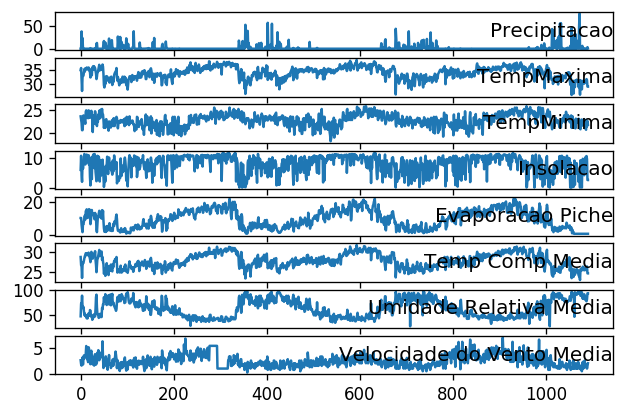

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
        
    return [y_hats, y_tests]

In [14]:
def metrics(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    percentual = 100
    n = len(y_hats)
    j = 1
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_max[i] - y_tests_max[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1
    
    print('\nMinimum metrics')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))
    
    j = 1
    percentual = 100
    print('\nAccuracy')
    while percentual > 0:
        count = 0
        n = len(y_hats_max)
        
        for i in range(0,len(y_hats_max)):
            error = abs(y_hats_min[i] - y_tests_min[i])
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = round((count/n)*100,2)
        if percentual > 0:
            print('{}% of predictions missed {} point(s) or less'.format(percentual, j))
        j += 1

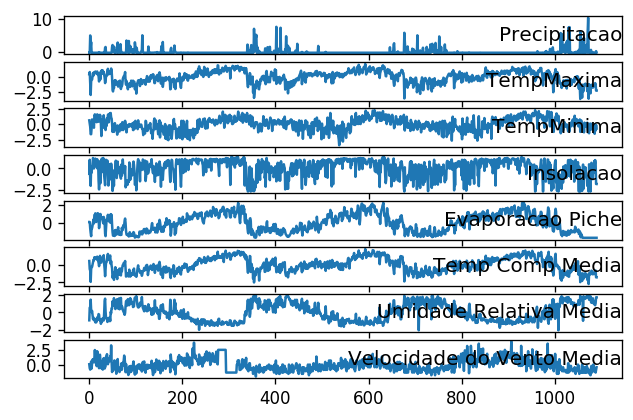

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7504 - mean_squared_error: 0.8843 - val_loss: 0.8506 - val_mean_squared_error: 1.3218
Epoch 2/1000
 - 1s - loss: 0.6656 - mean_squared_error: 0.7297 - val_loss: 0.8409 - val_mean_squared_error: 1.4107
Epoch 3/1000
 - 1s - loss: 0.5999 - mean_squared_error: 0.6287 - val_loss: 0.9411 - val_mean_squared_error: 1.5545
Epoch 4/1000
 - 1s - loss: 0.5697 - mean_squared_error: 0.5670 - val_loss: 0.8934 - val_mean_squared_error: 1.4138
Epoch 5/1000
 - 1s - loss: 0.5533 - mean_squared_error: 0.5312 - val_loss: 0.9461 - val_mean_squared_error: 1.5813
Epoch 6/1000
 - 1s - loss: 0.5438 - mean_squared_error: 0.5113 - val_loss: 0.9992 - val_mean_squared_error: 1.9146
Epoch 7/1000
 - 1s - loss: 0.5317 - mean_squared_error: 0.4929 - val_loss: 0.9930 - val_mean_squared_error: 1.8444
Epoch 8/1000
 - 1s - loss: 0.5214 - mean_squared_error: 0.4790 - val_loss: 1.0001 - val_mean_squared_error: 2.0002
Epoch 9/1000
 - 1s - loss: 0.5144 -

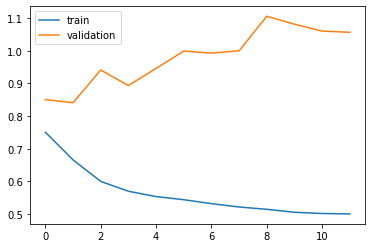


predict: [[-3.91797651 33.57964149]]
real:      [[-14.21823396  32.37202343]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7396 - mean_squared_error: 0.8646 - val_loss: 0.6834 - val_mean_squared_error: 0.4689
Epoch 2/1000
 - 1s - loss: 0.6142 - mean_squared_error: 0.6486 - val_loss: 0.7779 - val_mean_squared_error: 0.6428
Epoch 3/1000
 - 1s - loss: 0.5878 - mean_squared_error: 0.5890 - val_loss: 0.6933 - val_mean_squared_error: 0.4876
Epoch 4/1000
 - 1s - loss: 0.5645 - mean_squared_error: 0.5442 - val_loss: 0.7315 - val_mean_squared_error: 0.5415
Epoch 5/1000
 - 1s - loss: 0.5527 - mean_squared_error: 0.5279 - val_loss: 0.7188 - val_mean_squared_error: 0.5195
Epoch 6/1000
 - 1s - loss: 0.5403 - mean_squared_error: 0.5062 - val_loss: 0.7137 - val_mean_squared_error: 0.5100
Epoch 7/1000
 - 1s - loss: 0.5338 - mean_squared_error: 0.4959 - val_loss: 0.6910 - val_mean_squared_error: 0.4826
Epoch 8/1000
 - 1s - loss: 0.5257 - mean_squared_error: 0.4851 - val_l

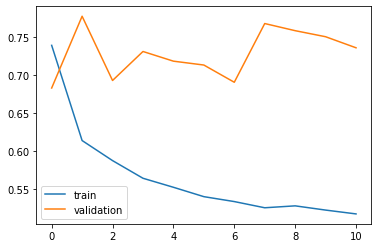


predict: [[-2.31489145 33.5830261 ]]
real:      [[-14.21823396  33.70050329]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7605 - mean_squared_error: 0.8854 - val_loss: 0.2660 - val_mean_squared_error: 0.1102
Epoch 2/1000
 - 1s - loss: 0.6467 - mean_squared_error: 0.6828 - val_loss: 0.2744 - val_mean_squared_error: 0.0976
Epoch 3/1000
 - 1s - loss: 0.5823 - mean_squared_error: 0.5791 - val_loss: 0.3001 - val_mean_squared_error: 0.1203
Epoch 4/1000
 - 1s - loss: 0.5644 - mean_squared_error: 0.5495 - val_loss: 0.3536 - val_mean_squared_error: 0.1629
Epoch 5/1000
 - 1s - loss: 0.5502 - mean_squared_error: 0.5310 - val_loss: 0.3610 - val_mean_squared_error: 0.1794
Epoch 6/1000
 - 1s - loss: 0.5460 - mean_squared_error: 0.5177 - val_loss: 0.4473 - val_mean_squared_error: 0.2800
Epoch 7/1000
 - 1s - loss: 0.5360 - mean_squared_error: 0.5067 - val_loss: 0.4487 - val_mean_squared_error: 0.2999
Epoch 8/1000
 - 1s - loss: 0.5293 - mean_squared_error: 0.4926 - val_l

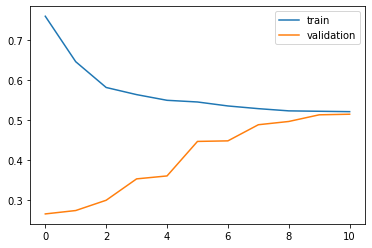


predict: [[-3.21075747 33.8392874 ]]
real:      [[-6.557701  31.7077835]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7653 - mean_squared_error: 0.9046 - val_loss: 1.3332 - val_mean_squared_error: 1.8418
Epoch 2/1000
 - 1s - loss: 0.6104 - mean_squared_error: 0.6238 - val_loss: 1.1156 - val_mean_squared_error: 1.4360
Epoch 3/1000
 - 1s - loss: 0.5569 - mean_squared_error: 0.5319 - val_loss: 1.0044 - val_mean_squared_error: 1.1657
Epoch 4/1000
 - 1s - loss: 0.5490 - mean_squared_error: 0.5179 - val_loss: 1.1753 - val_mean_squared_error: 1.5575
Epoch 5/1000
 - 1s - loss: 0.5383 - mean_squared_error: 0.5052 - val_loss: 1.1344 - val_mean_squared_error: 1.4031
Epoch 6/1000
 - 1s - loss: 0.5302 - mean_squared_error: 0.4873 - val_loss: 1.1732 - val_mean_squared_error: 1.4957
Epoch 7/1000
 - 1s - loss: 0.5194 - mean_squared_error: 0.4746 - val_loss: 1.2053 - val_mean_squared_error: 1.4790
Epoch 8/1000
 - 1s - loss: 0.5125 - mean_squared_error: 0.4647 - val_loss:

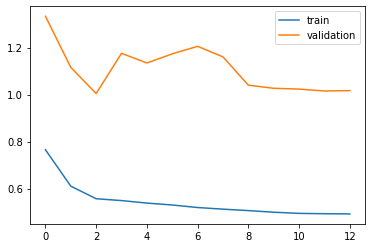


predict: [[-4.25958437 33.49561625]]
real:      [[-5.2809455  34.03262326]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7544 - mean_squared_error: 0.9008 - val_loss: 1.1187 - val_mean_squared_error: 1.2515
Epoch 2/1000
 - 1s - loss: 0.6425 - mean_squared_error: 0.6805 - val_loss: 1.1385 - val_mean_squared_error: 1.3323
Epoch 3/1000
 - 1s - loss: 0.5882 - mean_squared_error: 0.5911 - val_loss: 1.0311 - val_mean_squared_error: 1.1033
Epoch 4/1000
 - 1s - loss: 0.5635 - mean_squared_error: 0.5419 - val_loss: 1.0028 - val_mean_squared_error: 1.0596
Epoch 5/1000
 - 1s - loss: 0.5507 - mean_squared_error: 0.5228 - val_loss: 1.0632 - val_mean_squared_error: 1.1361
Epoch 6/1000
 - 1s - loss: 0.5390 - mean_squared_error: 0.5084 - val_loss: 1.1141 - val_mean_squared_error: 1.2413
Epoch 7/1000
 - 1s - loss: 0.5337 - mean_squared_error: 0.4960 - val_loss: 1.1005 - val_mean_squared_error: 1.2213
Epoch 8/1000
 - 1s - loss: 0.5238 - mean_squared_error: 0.4870 - val_los

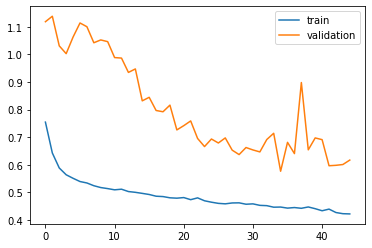


predict: [[-5.35067073 33.2428039 ]]
real:      [[-7.51526762 30.54536362]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7469 - mean_squared_error: 0.8632 - val_loss: 0.9044 - val_mean_squared_error: 0.8194
Epoch 2/1000
 - 1s - loss: 0.6554 - mean_squared_error: 0.6838 - val_loss: 0.8672 - val_mean_squared_error: 0.7594
Epoch 3/1000
 - 1s - loss: 0.5856 - mean_squared_error: 0.5733 - val_loss: 0.8055 - val_mean_squared_error: 0.6631
Epoch 4/1000
 - 1s - loss: 0.5621 - mean_squared_error: 0.5429 - val_loss: 0.8874 - val_mean_squared_error: 0.8033
Epoch 5/1000
 - 1s - loss: 0.5488 - mean_squared_error: 0.5222 - val_loss: 0.8475 - val_mean_squared_error: 0.7720
Epoch 6/1000
 - 1s - loss: 0.5378 - mean_squared_error: 0.5060 - val_loss: 0.8429 - val_mean_squared_error: 0.7749
Epoch 7/1000
 - 1s - loss: 0.5285 - mean_squared_error: 0.4876 - val_loss: 0.8848 - val_mean_squared_error: 0.9074
Epoch 8/1000
 - 1s - loss: 0.5234 - mean_squared_error: 0.4871 - val_los

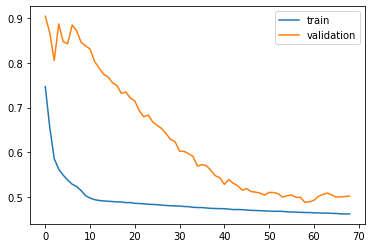


predict: [[-5.01969385 32.93587428]]
real:      [[-8.47283424 30.87748359]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7073 - mean_squared_error: 0.7884 - val_loss: 0.7235 - val_mean_squared_error: 0.6686
Epoch 2/1000
 - 1s - loss: 0.6242 - mean_squared_error: 0.6293 - val_loss: 0.7644 - val_mean_squared_error: 0.7800
Epoch 3/1000
 - 1s - loss: 0.5730 - mean_squared_error: 0.5615 - val_loss: 0.8118 - val_mean_squared_error: 0.9199
Epoch 4/1000
 - 1s - loss: 0.5571 - mean_squared_error: 0.5325 - val_loss: 0.8619 - val_mean_squared_error: 1.1134
Epoch 5/1000
 - 1s - loss: 0.5403 - mean_squared_error: 0.5109 - val_loss: 0.8610 - val_mean_squared_error: 1.1794
Epoch 6/1000
 - 1s - loss: 0.5285 - mean_squared_error: 0.4873 - val_loss: 0.8604 - val_mean_squared_error: 1.2886
Epoch 7/1000
 - 1s - loss: 0.5213 - mean_squared_error: 0.4764 - val_loss: 0.8782 - val_mean_squared_error: 1.2531
Epoch 8/1000
 - 1s - loss: 0.5153 - mean_squared_error: 0.4710 - val_los

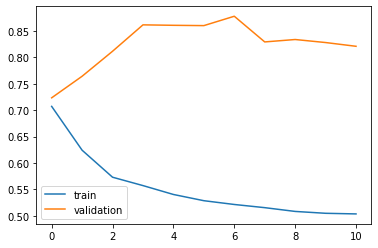


predict: [[-4.72963412 33.91879865]]
real:      [[-8.79202311 32.03990347]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7012 - mean_squared_error: 0.8085 - val_loss: 0.8793 - val_mean_squared_error: 1.4560
Epoch 2/1000
 - 1s - loss: 0.6099 - mean_squared_error: 0.6315 - val_loss: 0.7830 - val_mean_squared_error: 1.2128
Epoch 3/1000
 - 1s - loss: 0.5687 - mean_squared_error: 0.5533 - val_loss: 0.7085 - val_mean_squared_error: 0.8058
Epoch 4/1000
 - 1s - loss: 0.5522 - mean_squared_error: 0.5280 - val_loss: 0.7857 - val_mean_squared_error: 0.9671
Epoch 5/1000
 - 1s - loss: 0.5417 - mean_squared_error: 0.5139 - val_loss: 0.7353 - val_mean_squared_error: 0.8469
Epoch 6/1000
 - 1s - loss: 0.5423 - mean_squared_error: 0.5104 - val_loss: 0.7801 - val_mean_squared_error: 0.9254
Epoch 7/1000
 - 1s - loss: 0.5377 - mean_squared_error: 0.5048 - val_loss: 0.8213 - val_mean_squared_error: 0.9914
Epoch 8/1000
 - 1s - loss: 0.5285 - mean_squared_error: 0.4902 - val_los

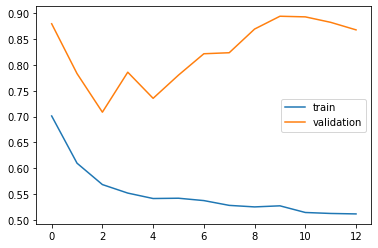


predict: [[-5.23286239 33.52875942]]
real:      [[-9.74958973 33.03626336]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7629 - mean_squared_error: 0.8934 - val_loss: 0.4098 - val_mean_squared_error: 0.2875
Epoch 2/1000
 - 1s - loss: 0.6778 - mean_squared_error: 0.7276 - val_loss: 0.5030 - val_mean_squared_error: 0.4484
Epoch 3/1000
 - 1s - loss: 0.6151 - mean_squared_error: 0.6202 - val_loss: 0.4533 - val_mean_squared_error: 0.3821
Epoch 4/1000
 - 1s - loss: 0.5600 - mean_squared_error: 0.5273 - val_loss: 0.5691 - val_mean_squared_error: 0.5992
Epoch 5/1000
 - 1s - loss: 0.5478 - mean_squared_error: 0.5177 - val_loss: 0.5363 - val_mean_squared_error: 0.5381
Epoch 6/1000
 - 1s - loss: 0.5323 - mean_squared_error: 0.4963 - val_loss: 0.5868 - val_mean_squared_error: 0.6000
Epoch 7/1000
 - 1s - loss: 0.5248 - mean_squared_error: 0.4836 - val_loss: 0.6250 - val_mean_squared_error: 0.6660
Epoch 8/1000
 - 1s - loss: 0.5264 - mean_squared_error: 0.4856 - val_los

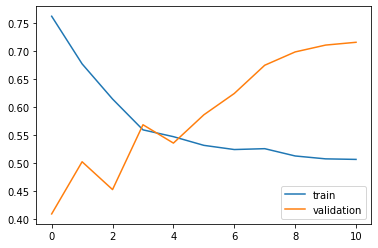


predict: [[-4.90421353 33.68475437]]
real:      [[-10.70715635  34.36474322]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7797 - mean_squared_error: 0.9427 - val_loss: 0.5883 - val_mean_squared_error: 0.3750
Epoch 2/1000
 - 1s - loss: 0.6934 - mean_squared_error: 0.7669 - val_loss: 0.4984 - val_mean_squared_error: 0.2795
Epoch 3/1000
 - 1s - loss: 0.5955 - mean_squared_error: 0.5964 - val_loss: 0.5361 - val_mean_squared_error: 0.3290
Epoch 4/1000
 - 1s - loss: 0.5571 - mean_squared_error: 0.5389 - val_loss: 0.4908 - val_mean_squared_error: 0.2731
Epoch 5/1000
 - 1s - loss: 0.5418 - mean_squared_error: 0.5145 - val_loss: 0.5869 - val_mean_squared_error: 0.4189
Epoch 6/1000
 - 1s - loss: 0.5393 - mean_squared_error: 0.5078 - val_loss: 0.6363 - val_mean_squared_error: 0.4917
Epoch 7/1000
 - 1s - loss: 0.5298 - mean_squared_error: 0.4959 - val_loss: 0.5854 - val_mean_squared_error: 0.4499
Epoch 8/1000
 - 1s - loss: 0.5219 - mean_squared_error: 0.4860 - val_l

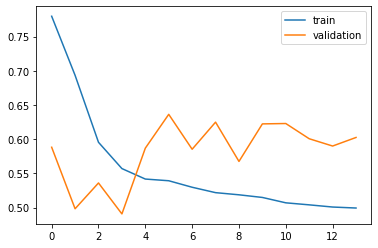


predict: [[-5.11942944 33.47133931]]
real:      [[-7.19607874 33.86656328]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7170 - mean_squared_error: 0.8164 - val_loss: 0.4211 - val_mean_squared_error: 0.2992
Epoch 2/1000
 - 1s - loss: 0.6169 - mean_squared_error: 0.6302 - val_loss: 0.4366 - val_mean_squared_error: 0.3733
Epoch 3/1000
 - 1s - loss: 0.5726 - mean_squared_error: 0.5654 - val_loss: 0.4941 - val_mean_squared_error: 0.4041
Epoch 4/1000
 - 1s - loss: 0.5600 - mean_squared_error: 0.5481 - val_loss: 0.4894 - val_mean_squared_error: 0.4013
Epoch 5/1000
 - 1s - loss: 0.5481 - mean_squared_error: 0.5311 - val_loss: 0.4854 - val_mean_squared_error: 0.4255
Epoch 6/1000
 - 1s - loss: 0.5425 - mean_squared_error: 0.5207 - val_loss: 0.5241 - val_mean_squared_error: 0.4787
Epoch 7/1000
 - 1s - loss: 0.5354 - mean_squared_error: 0.5120 - val_loss: 0.5102 - val_mean_squared_error: 0.5123
Epoch 8/1000
 - 1s - loss: 0.5318 - mean_squared_error: 0.5072 - val_los

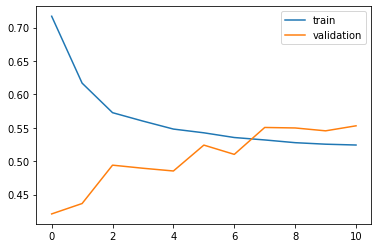


predict: [[-4.52918019 33.78012521]]
real:      [[-7.19607874 33.03626336]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7058 - mean_squared_error: 0.7858 - val_loss: 0.7676 - val_mean_squared_error: 0.5909
Epoch 2/1000
 - 1s - loss: 0.6060 - mean_squared_error: 0.6115 - val_loss: 0.8127 - val_mean_squared_error: 0.6700
Epoch 3/1000
 - 1s - loss: 0.5653 - mean_squared_error: 0.5535 - val_loss: 0.8099 - val_mean_squared_error: 0.6655
Epoch 4/1000
 - 1s - loss: 0.5470 - mean_squared_error: 0.5223 - val_loss: 0.8716 - val_mean_squared_error: 0.7682
Epoch 5/1000
 - 1s - loss: 0.5408 - mean_squared_error: 0.5150 - val_loss: 0.8502 - val_mean_squared_error: 0.7480
Epoch 6/1000
 - 1s - loss: 0.5301 - mean_squared_error: 0.5066 - val_loss: 0.7848 - val_mean_squared_error: 0.6522
Epoch 7/1000
 - 1s - loss: 0.5254 - mean_squared_error: 0.4884 - val_loss: 0.8230 - val_mean_squared_error: 0.7043
Epoch 8/1000
 - 1s - loss: 0.5172 - mean_squared_error: 0.4755 - val_los

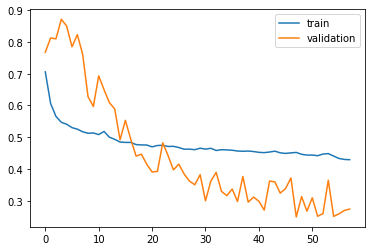


predict: [[-6.66911349 32.57850716]]
real:      [[-7.51526762 33.86656328]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7228 - mean_squared_error: 0.8349 - val_loss: 1.1002 - val_mean_squared_error: 2.2581
Epoch 2/1000
 - 1s - loss: 0.6098 - mean_squared_error: 0.6202 - val_loss: 1.1525 - val_mean_squared_error: 2.3766
Epoch 3/1000
 - 1s - loss: 0.5740 - mean_squared_error: 0.5690 - val_loss: 1.0921 - val_mean_squared_error: 2.3660
Epoch 4/1000
 - 1s - loss: 0.5516 - mean_squared_error: 0.5316 - val_loss: 1.2089 - val_mean_squared_error: 2.6742
Epoch 5/1000
 - 1s - loss: 0.5406 - mean_squared_error: 0.5240 - val_loss: 1.1342 - val_mean_squared_error: 2.4004
Epoch 6/1000
 - 1s - loss: 0.5333 - mean_squared_error: 0.5091 - val_loss: 1.2245 - val_mean_squared_error: 2.7224
Epoch 7/1000
 - 1s - loss: 0.5311 - mean_squared_error: 0.5015 - val_loss: 1.1143 - val_mean_squared_error: 2.4100
Epoch 8/1000
 - 1s - loss: 0.5244 - mean_squared_error: 0.4950 - val_los

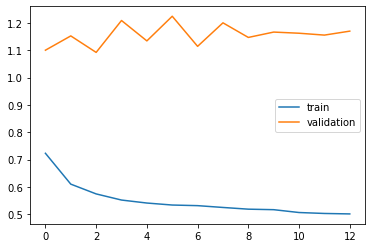


predict: [[-4.41677989 33.64787247]]
real:      [[-8.47283424 32.03990347]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7378 - mean_squared_error: 0.8474 - val_loss: 0.7978 - val_mean_squared_error: 1.0065
Epoch 2/1000
 - 1s - loss: 0.6482 - mean_squared_error: 0.6818 - val_loss: 0.8062 - val_mean_squared_error: 1.1179
Epoch 3/1000
 - 1s - loss: 0.5830 - mean_squared_error: 0.5779 - val_loss: 0.8060 - val_mean_squared_error: 1.1038
Epoch 4/1000
 - 1s - loss: 0.5548 - mean_squared_error: 0.5387 - val_loss: 0.8344 - val_mean_squared_error: 1.1958
Epoch 5/1000
 - 1s - loss: 0.5406 - mean_squared_error: 0.5114 - val_loss: 0.7714 - val_mean_squared_error: 1.1452
Epoch 6/1000
 - 1s - loss: 0.5350 - mean_squared_error: 0.5062 - val_loss: 0.7885 - val_mean_squared_error: 1.0227
Epoch 7/1000
 - 1s - loss: 0.5273 - mean_squared_error: 0.4871 - val_loss: 0.7857 - val_mean_squared_error: 1.0049
Epoch 8/1000
 - 1s - loss: 0.5218 - mean_squared_error: 0.4881 - val_los

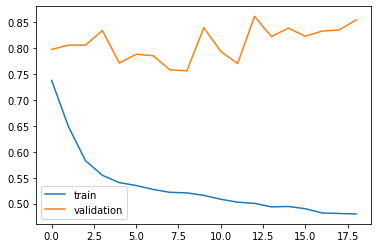


predict: [[-2.79118952 33.36205516]]
real:      [[-17.41012269  34.19868324]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7467 - mean_squared_error: 0.8742 - val_loss: 0.9339 - val_mean_squared_error: 0.8723
Epoch 2/1000
 - 1s - loss: 0.6274 - mean_squared_error: 0.6568 - val_loss: 0.8665 - val_mean_squared_error: 0.7547
Epoch 3/1000
 - 1s - loss: 0.5659 - mean_squared_error: 0.5578 - val_loss: 0.7900 - val_mean_squared_error: 0.6244
Epoch 4/1000
 - 1s - loss: 0.5468 - mean_squared_error: 0.5191 - val_loss: 0.8035 - val_mean_squared_error: 0.6539
Epoch 5/1000
 - 1s - loss: 0.5421 - mean_squared_error: 0.5091 - val_loss: 0.8372 - val_mean_squared_error: 0.7025
Epoch 6/1000
 - 1s - loss: 0.5287 - mean_squared_error: 0.4948 - val_loss: 0.8721 - val_mean_squared_error: 0.7977
Epoch 7/1000
 - 1s - loss: 0.5270 - mean_squared_error: 0.4908 - val_loss: 0.8719 - val_mean_squared_error: 0.7779
Epoch 8/1000
 - 1s - loss: 0.5242 - mean_squared_error: 0.4960 - val_l

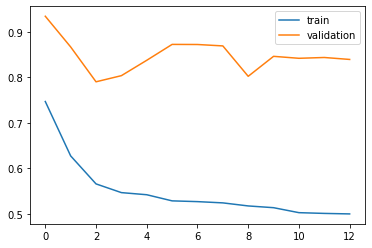


predict: [[-4.12497051 33.6437006 ]]
real:      [[-12.30310072  34.19868324]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7581 - mean_squared_error: 0.8825 - val_loss: 1.0943 - val_mean_squared_error: 1.3193
Epoch 2/1000
 - 1s - loss: 0.6940 - mean_squared_error: 0.7555 - val_loss: 1.0271 - val_mean_squared_error: 1.2610
Epoch 3/1000
 - 1s - loss: 0.6343 - mean_squared_error: 0.6497 - val_loss: 1.0835 - val_mean_squared_error: 1.4110
Epoch 4/1000
 - 1s - loss: 0.5686 - mean_squared_error: 0.5458 - val_loss: 1.0277 - val_mean_squared_error: 1.2881
Epoch 5/1000
 - 1s - loss: 0.5404 - mean_squared_error: 0.5064 - val_loss: 1.1062 - val_mean_squared_error: 1.4217
Epoch 6/1000
 - 1s - loss: 0.5391 - mean_squared_error: 0.5175 - val_loss: 1.0346 - val_mean_squared_error: 1.2414
Epoch 7/1000
 - 1s - loss: 0.5283 - mean_squared_error: 0.4898 - val_loss: 1.0487 - val_mean_squared_error: 1.2118
Epoch 8/1000
 - 1s - loss: 0.5205 - mean_squared_error: 0.4799 - val_l

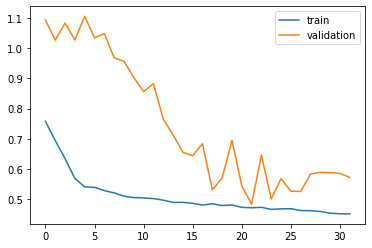


predict: [[-4.99866264 33.00440388]]
real:      [[-8.47283424 32.20596345]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7861 - mean_squared_error: 0.9632 - val_loss: 1.9657 - val_mean_squared_error: 4.4523
Epoch 2/1000
 - 1s - loss: 0.6539 - mean_squared_error: 0.7061 - val_loss: 2.0134 - val_mean_squared_error: 4.9243
Epoch 3/1000
 - 1s - loss: 0.5800 - mean_squared_error: 0.5905 - val_loss: 2.0010 - val_mean_squared_error: 4.8875
Epoch 4/1000
 - 1s - loss: 0.5474 - mean_squared_error: 0.5246 - val_loss: 2.0384 - val_mean_squared_error: 5.1158
Epoch 5/1000
 - 1s - loss: 0.5316 - mean_squared_error: 0.4967 - val_loss: 2.0511 - val_mean_squared_error: 5.2499
Epoch 6/1000
 - 1s - loss: 0.5262 - mean_squared_error: 0.4934 - val_loss: 1.9912 - val_mean_squared_error: 5.0548
Epoch 7/1000
 - 1s - loss: 0.5314 - mean_squared_error: 0.4936 - val_loss: 2.0030 - val_mean_squared_error: 4.9328
Epoch 8/1000
 - 1s - loss: 0.5217 - mean_squared_error: 0.4834 - val_los

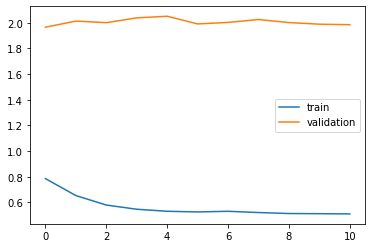


predict: [[-6.22811041 33.95586107]]
real:      [[-6.557701   30.71142361]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7235 - mean_squared_error: 0.8254 - val_loss: 1.6345 - val_mean_squared_error: 2.6913
Epoch 2/1000
 - 1s - loss: 0.6063 - mean_squared_error: 0.6153 - val_loss: 1.5439 - val_mean_squared_error: 2.3957
Epoch 3/1000
 - 1s - loss: 0.5604 - mean_squared_error: 0.5323 - val_loss: 1.4523 - val_mean_squared_error: 2.1637
Epoch 4/1000
 - 1s - loss: 0.5403 - mean_squared_error: 0.5047 - val_loss: 1.5410 - val_mean_squared_error: 2.4353
Epoch 5/1000
 - 1s - loss: 0.5312 - mean_squared_error: 0.4866 - val_loss: 1.5602 - val_mean_squared_error: 2.5072
Epoch 6/1000
 - 1s - loss: 0.5251 - mean_squared_error: 0.4857 - val_loss: 1.4889 - val_mean_squared_error: 2.2687
Epoch 7/1000
 - 1s - loss: 0.5220 - mean_squared_error: 0.4766 - val_loss: 1.4907 - val_mean_squared_error: 2.2625
Epoch 8/1000
 - 1s - loss: 0.5161 - mean_squared_error: 0.4656 - val_los

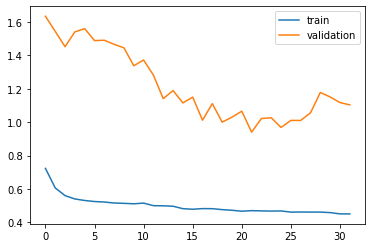


predict: [[-7.99676687 33.41689245]]
real:      [[-23.79390016  31.20960355]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7399 - mean_squared_error: 0.8401 - val_loss: 0.7773 - val_mean_squared_error: 0.6088
Epoch 2/1000
 - 1s - loss: 0.6405 - mean_squared_error: 0.6586 - val_loss: 0.8303 - val_mean_squared_error: 0.7069
Epoch 3/1000
 - 1s - loss: 0.5712 - mean_squared_error: 0.5471 - val_loss: 0.7387 - val_mean_squared_error: 0.5512
Epoch 4/1000
 - 1s - loss: 0.5481 - mean_squared_error: 0.5187 - val_loss: 0.7256 - val_mean_squared_error: 0.5274
Epoch 5/1000
 - 1s - loss: 0.5314 - mean_squared_error: 0.4931 - val_loss: 0.8345 - val_mean_squared_error: 0.7221
Epoch 6/1000
 - 1s - loss: 0.5274 - mean_squared_error: 0.4903 - val_loss: 0.7182 - val_mean_squared_error: 0.5322
Epoch 7/1000
 - 1s - loss: 0.5164 - mean_squared_error: 0.4760 - val_loss: 0.8291 - val_mean_squared_error: 0.7035
Epoch 8/1000
 - 1s - loss: 0.5147 - mean_squared_error: 0.4719 - val_l

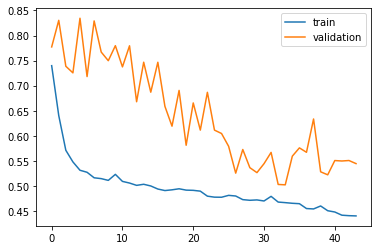


predict: [[-4.90038708 32.76758913]]
real:      [[-13.26066734  31.04354357]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7303 - mean_squared_error: 0.8502 - val_loss: 1.0727 - val_mean_squared_error: 1.9248
Epoch 2/1000
 - 1s - loss: 0.6161 - mean_squared_error: 0.6380 - val_loss: 0.9730 - val_mean_squared_error: 1.4791
Epoch 3/1000
 - 1s - loss: 0.5605 - mean_squared_error: 0.5334 - val_loss: 0.9969 - val_mean_squared_error: 1.4626
Epoch 4/1000
 - 1s - loss: 0.5399 - mean_squared_error: 0.5035 - val_loss: 1.0322 - val_mean_squared_error: 1.6631
Epoch 5/1000
 - 1s - loss: 0.5277 - mean_squared_error: 0.4879 - val_loss: 1.0400 - val_mean_squared_error: 1.5063
Epoch 6/1000
 - 1s - loss: 0.5294 - mean_squared_error: 0.4857 - val_loss: 1.0738 - val_mean_squared_error: 1.5649
Epoch 7/1000
 - 1s - loss: 0.5224 - mean_squared_error: 0.4790 - val_loss: 1.1148 - val_mean_squared_error: 1.6655
Epoch 8/1000
 - 1s - loss: 0.5169 - mean_squared_error: 0.4657 - val_l

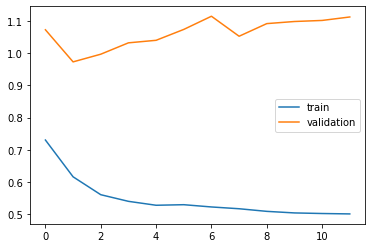


predict: [[-5.42525991 33.76499189]]
real:      [[-7.19607874 32.03990347]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7500 - mean_squared_error: 0.8836 - val_loss: 0.5432 - val_mean_squared_error: 0.3281
Epoch 2/1000
 - 1s - loss: 0.6353 - mean_squared_error: 0.6610 - val_loss: 0.5625 - val_mean_squared_error: 0.3189
Epoch 3/1000
 - 1s - loss: 0.5747 - mean_squared_error: 0.5545 - val_loss: 0.5863 - val_mean_squared_error: 0.3478
Epoch 4/1000
 - 1s - loss: 0.5502 - mean_squared_error: 0.5286 - val_loss: 0.5164 - val_mean_squared_error: 0.2748
Epoch 5/1000
 - 1s - loss: 0.5537 - mean_squared_error: 0.5258 - val_loss: 0.5405 - val_mean_squared_error: 0.3021
Epoch 6/1000
 - 1s - loss: 0.5435 - mean_squared_error: 0.5123 - val_loss: 0.5363 - val_mean_squared_error: 0.2891
Epoch 7/1000
 - 1s - loss: 0.5296 - mean_squared_error: 0.4886 - val_loss: 0.5140 - val_mean_squared_error: 0.2702
Epoch 8/1000
 - 1s - loss: 0.5403 - mean_squared_error: 0.4993 - val_los

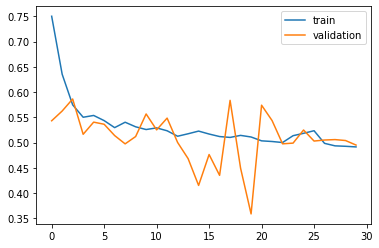


predict: [[-6.12249672 33.07966677]]
real:      [[-14.8566117   34.53080321]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7288 - mean_squared_error: 0.8409 - val_loss: 0.5930 - val_mean_squared_error: 0.4813
Epoch 2/1000
 - 0s - loss: 0.6110 - mean_squared_error: 0.6274 - val_loss: 0.5607 - val_mean_squared_error: 0.3516
Epoch 3/1000
 - 0s - loss: 0.5670 - mean_squared_error: 0.5427 - val_loss: 0.4866 - val_mean_squared_error: 0.2576
Epoch 4/1000
 - 0s - loss: 0.5381 - mean_squared_error: 0.4975 - val_loss: 0.4343 - val_mean_squared_error: 0.2160
Epoch 5/1000
 - 0s - loss: 0.5226 - mean_squared_error: 0.4798 - val_loss: 0.4001 - val_mean_squared_error: 0.2073
Epoch 6/1000
 - 0s - loss: 0.5152 - mean_squared_error: 0.4711 - val_loss: 0.3629 - val_mean_squared_error: 0.2003
Epoch 7/1000
 - 0s - loss: 0.5104 - mean_squared_error: 0.4664 - val_loss: 0.3463 - val_mean_squared_error: 0.1771
Epoch 8/1000
 - 0s - loss: 0.5062 - mean_squared_error: 0.4577 - val_l

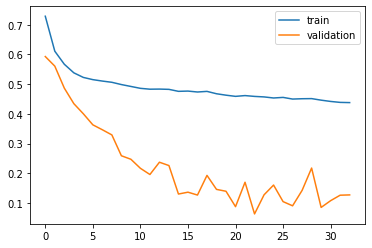


predict: [[-4.47687154 32.92188323]]
real:      [[-6.87688987 33.03626336]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7318 - mean_squared_error: 0.8461 - val_loss: 0.6409 - val_mean_squared_error: 0.5590
Epoch 2/1000
 - 0s - loss: 0.5925 - mean_squared_error: 0.6027 - val_loss: 0.3878 - val_mean_squared_error: 0.2615
Epoch 3/1000
 - 0s - loss: 0.5560 - mean_squared_error: 0.5235 - val_loss: 0.4595 - val_mean_squared_error: 0.2848
Epoch 4/1000
 - 0s - loss: 0.5394 - mean_squared_error: 0.5006 - val_loss: 0.3522 - val_mean_squared_error: 0.2259
Epoch 5/1000
 - 0s - loss: 0.5292 - mean_squared_error: 0.4872 - val_loss: 0.3572 - val_mean_squared_error: 0.2360
Epoch 6/1000
 - 0s - loss: 0.5223 - mean_squared_error: 0.4856 - val_loss: 0.3650 - val_mean_squared_error: 0.2401
Epoch 7/1000
 - 0s - loss: 0.5147 - mean_squared_error: 0.4763 - val_loss: 0.3726 - val_mean_squared_error: 0.2492
Epoch 8/1000
 - 0s - loss: 0.5133 - mean_squared_error: 0.4704 - val_los

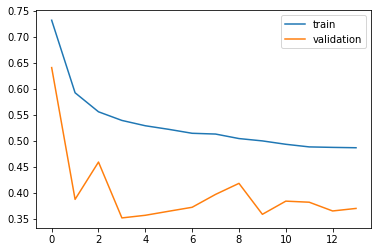


predict: [[-4.87226088 33.60193041]]
real:      [[-7.19607874 33.03626336]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7094 - mean_squared_error: 0.8097 - val_loss: 0.3532 - val_mean_squared_error: 0.1475
Epoch 2/1000
 - 0s - loss: 0.6094 - mean_squared_error: 0.6245 - val_loss: 0.3593 - val_mean_squared_error: 0.1512
Epoch 3/1000
 - 0s - loss: 0.5549 - mean_squared_error: 0.5319 - val_loss: 0.3380 - val_mean_squared_error: 0.1304
Epoch 4/1000
 - 0s - loss: 0.5330 - mean_squared_error: 0.4947 - val_loss: 0.2961 - val_mean_squared_error: 0.1093
Epoch 5/1000
 - 0s - loss: 0.5251 - mean_squared_error: 0.4802 - val_loss: 0.3238 - val_mean_squared_error: 0.1286
Epoch 6/1000
 - 0s - loss: 0.5182 - mean_squared_error: 0.4713 - val_loss: 0.2900 - val_mean_squared_error: 0.0848
Epoch 7/1000
 - 0s - loss: 0.5092 - mean_squared_error: 0.4643 - val_loss: 0.3274 - val_mean_squared_error: 0.1094
Epoch 8/1000
 - 0s - loss: 0.5030 - mean_squared_error: 0.4528 - val_los

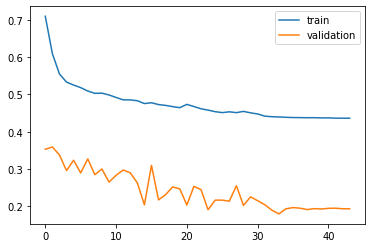


predict: [[-5.2228678  33.13864348]]
real:      [[-7.51526762 33.86656328]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7678 - mean_squared_error: 0.9091 - val_loss: 0.4553 - val_mean_squared_error: 0.3325
Epoch 2/1000
 - 0s - loss: 0.7030 - mean_squared_error: 0.7825 - val_loss: 0.3051 - val_mean_squared_error: 0.1805
Epoch 3/1000
 - 0s - loss: 0.6445 - mean_squared_error: 0.6717 - val_loss: 0.3188 - val_mean_squared_error: 0.1922
Epoch 4/1000
 - 0s - loss: 0.5709 - mean_squared_error: 0.5441 - val_loss: 0.2469 - val_mean_squared_error: 0.1210
Epoch 5/1000
 - 0s - loss: 0.5441 - mean_squared_error: 0.5053 - val_loss: 0.3443 - val_mean_squared_error: 0.1944
Epoch 6/1000
 - 0s - loss: 0.5257 - mean_squared_error: 0.4845 - val_loss: 0.3625 - val_mean_squared_error: 0.1994
Epoch 7/1000
 - 0s - loss: 0.5166 - mean_squared_error: 0.4752 - val_loss: 0.2560 - val_mean_squared_error: 0.1201
Epoch 8/1000
 - 0s - loss: 0.5124 - mean_squared_error: 0.4665 - val_los

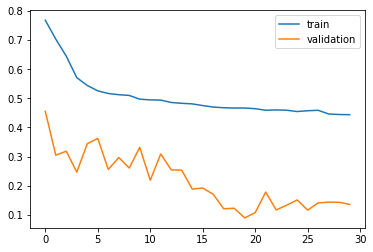


predict: [[-4.67577459 33.26511109]]
real:      [[-5.91932325 34.19868324]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7328 - mean_squared_error: 0.8542 - val_loss: 0.3359 - val_mean_squared_error: 0.1891
Epoch 2/1000
 - 0s - loss: 0.6088 - mean_squared_error: 0.6128 - val_loss: 0.4195 - val_mean_squared_error: 0.2144
Epoch 3/1000
 - 0s - loss: 0.5445 - mean_squared_error: 0.5125 - val_loss: 0.3261 - val_mean_squared_error: 0.1076
Epoch 4/1000
 - 0s - loss: 0.5289 - mean_squared_error: 0.4871 - val_loss: 0.4654 - val_mean_squared_error: 0.2266
Epoch 5/1000
 - 0s - loss: 0.5193 - mean_squared_error: 0.4755 - val_loss: 0.3338 - val_mean_squared_error: 0.1166
Epoch 6/1000
 - 0s - loss: 0.5136 - mean_squared_error: 0.4686 - val_loss: 0.3658 - val_mean_squared_error: 0.1348
Epoch 7/1000
 - 0s - loss: 0.5134 - mean_squared_error: 0.4649 - val_loss: 0.3780 - val_mean_squared_error: 0.1478
Epoch 8/1000
 - 0s - loss: 0.5064 - mean_squared_error: 0.4578 - val_los

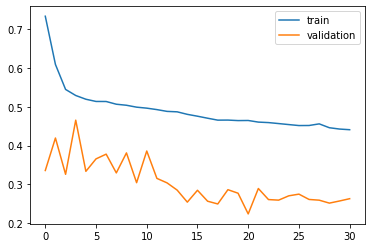


predict: [[-5.65952278 33.60036084]]
real:      [[-7.83445649 34.03262326]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7247 - mean_squared_error: 0.8254 - val_loss: 1.3328 - val_mean_squared_error: 1.8416
Epoch 2/1000
 - 0s - loss: 0.5934 - mean_squared_error: 0.5928 - val_loss: 1.1873 - val_mean_squared_error: 1.5350
Epoch 3/1000
 - 0s - loss: 0.5484 - mean_squared_error: 0.5177 - val_loss: 0.9457 - val_mean_squared_error: 1.0048
Epoch 4/1000
 - 0s - loss: 0.5288 - mean_squared_error: 0.4865 - val_loss: 1.0399 - val_mean_squared_error: 1.2159
Epoch 5/1000
 - 0s - loss: 0.5179 - mean_squared_error: 0.4740 - val_loss: 0.9442 - val_mean_squared_error: 1.0227
Epoch 6/1000
 - 0s - loss: 0.5073 - mean_squared_error: 0.4575 - val_loss: 0.8968 - val_mean_squared_error: 0.9193
Epoch 7/1000
 - 0s - loss: 0.5026 - mean_squared_error: 0.4546 - val_loss: 0.8698 - val_mean_squared_error: 0.8934
Epoch 8/1000
 - 0s - loss: 0.4941 - mean_squared_error: 0.4416 - val_los

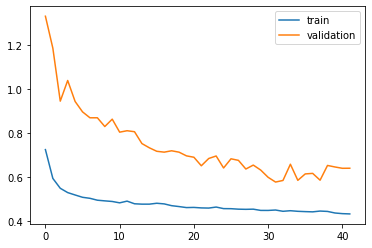


predict: [[-5.32172516 33.81041398]]
real:      [[-6.87688987 34.53080321]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7410 - mean_squared_error: 0.8677 - val_loss: 1.1326 - val_mean_squared_error: 2.4747
Epoch 2/1000
 - 0s - loss: 0.6255 - mean_squared_error: 0.6423 - val_loss: 0.9944 - val_mean_squared_error: 1.9300
Epoch 3/1000
 - 0s - loss: 0.5627 - mean_squared_error: 0.5357 - val_loss: 0.8691 - val_mean_squared_error: 1.3345
Epoch 4/1000
 - 0s - loss: 0.5332 - mean_squared_error: 0.4928 - val_loss: 0.8420 - val_mean_squared_error: 1.2287
Epoch 5/1000
 - 0s - loss: 0.5220 - mean_squared_error: 0.4785 - val_loss: 0.8399 - val_mean_squared_error: 1.2059
Epoch 6/1000
 - 0s - loss: 0.5153 - mean_squared_error: 0.4670 - val_loss: 0.9157 - val_mean_squared_error: 1.3229
Epoch 7/1000
 - 0s - loss: 0.5098 - mean_squared_error: 0.4615 - val_loss: 0.8416 - val_mean_squared_error: 1.1225
Epoch 8/1000
 - 0s - loss: 0.5095 - mean_squared_error: 0.4570 - val_los

Epoch 70/1000
 - 0s - loss: 0.4118 - mean_squared_error: 0.3358 - val_loss: 0.6028 - val_mean_squared_error: 0.6121
Epoch 71/1000
 - 0s - loss: 0.4113 - mean_squared_error: 0.3350 - val_loss: 0.6000 - val_mean_squared_error: 0.6071

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 72/1000
 - 0s - loss: 0.4106 - mean_squared_error: 0.3347 - val_loss: 0.6000 - val_mean_squared_error: 0.6075
Epoch 73/1000
 - 0s - loss: 0.4105 - mean_squared_error: 0.3347 - val_loss: 0.6009 - val_mean_squared_error: 0.6088
Epoch 74/1000
 - 0s - loss: 0.4105 - mean_squared_error: 0.3346 - val_loss: 0.6015 - val_mean_squared_error: 0.6101


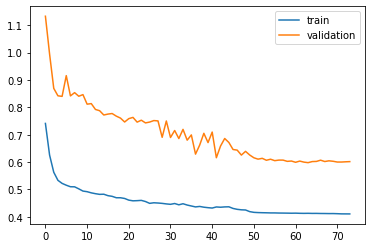


predict: [[-5.15387904 33.09430426]]
real:      [[-7.51526762 31.04354357]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7250 - mean_squared_error: 0.8213 - val_loss: 0.5169 - val_mean_squared_error: 0.5333
Epoch 2/1000
 - 0s - loss: 0.6393 - mean_squared_error: 0.6643 - val_loss: 0.5082 - val_mean_squared_error: 0.5085
Epoch 3/1000
 - 0s - loss: 0.5617 - mean_squared_error: 0.5371 - val_loss: 0.5302 - val_mean_squared_error: 0.3775
Epoch 4/1000
 - 0s - loss: 0.5319 - mean_squared_error: 0.4937 - val_loss: 0.5602 - val_mean_squared_error: 0.4318
Epoch 5/1000
 - 0s - loss: 0.5113 - mean_squared_error: 0.4693 - val_loss: 0.5303 - val_mean_squared_error: 0.4692
Epoch 6/1000
 - 0s - loss: 0.5011 - mean_squared_error: 0.4537 - val_loss: 0.5025 - val_mean_squared_error: 0.4026
Epoch 7/1000
 - 0s - loss: 0.5054 - mean_squared_error: 0.4551 - val_loss: 0.5306 - val_mean_squared_error: 0.4347
Epoch 8/1000
 - 0s - loss: 0.4946 - mean_squared_error: 0.4447 - val_los

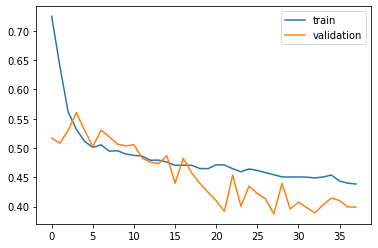


predict: [[-5.144996   33.80140617]]
real:      [[-14.8566117   33.86656328]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7446 - mean_squared_error: 0.8531 - val_loss: 0.7838 - val_mean_squared_error: 0.6266
Epoch 2/1000
 - 0s - loss: 0.6981 - mean_squared_error: 0.7601 - val_loss: 0.7808 - val_mean_squared_error: 0.6138
Epoch 3/1000
 - 0s - loss: 0.6486 - mean_squared_error: 0.6662 - val_loss: 0.7530 - val_mean_squared_error: 0.5780
Epoch 4/1000
 - 0s - loss: 0.5743 - mean_squared_error: 0.5498 - val_loss: 0.6017 - val_mean_squared_error: 0.3623
Epoch 5/1000
 - 0s - loss: 0.5374 - mean_squared_error: 0.4926 - val_loss: 0.5781 - val_mean_squared_error: 0.3422
Epoch 6/1000
 - 0s - loss: 0.5275 - mean_squared_error: 0.4909 - val_loss: 0.5925 - val_mean_squared_error: 0.3559
Epoch 7/1000
 - 0s - loss: 0.5176 - mean_squared_error: 0.4717 - val_loss: 0.5098 - val_mean_squared_error: 0.2714
Epoch 8/1000
 - 0s - loss: 0.5108 - mean_squared_error: 0.4665 - val_l

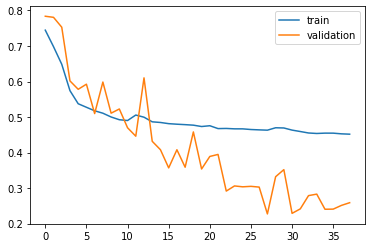


predict: [[-4.46816765 33.37548002]]
real:      [[-10.38796748  34.03262326]]



In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

standart_scaler = preprocessing.StandardScaler()
values_scaled = standart_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

result = NCV(dataset_scaled, days_to_predict, standart_scaler)

In [15]:
y_hats = result[0]
y_tests = result[1]

metrics(y_hats, y_tests)

Maximum metrics
Test RMSE -------------------------- 6.397
Test VARIANCE ---------------------- -0.01528
Test MAX-ERROR --------------------- 15.8
Test MEAN-ABSOLUTE-ERROR ----------- 4.915
Test MEDIAN-ABSOLUTE-ERROR --------- 3.4

Accuracy
6.67% of predictions missed 1 point(s) or less
13.33% of predictions missed 2 point(s) or less
26.67% of predictions missed 3 point(s) or less
10.0% of predictions missed 4 point(s) or less
10.0% of predictions missed 5 point(s) or less
6.67% of predictions missed 6 point(s) or less

Minimum metrics
Test RMSE -------------------------- 1.405
Test VARIANCE ---------------------- -0.03345
Test MAX-ERROR --------------------- 3.244
Test MEAN-ABSOLUTE-ERROR ----------- 1.155
Test MEDIAN-ABSOLUTE-ERROR --------- 0.8175

Accuracy
56.67% of predictions missed 1 point(s) or less
23.33% of predictions missed 2 point(s) or less
16.67% of predictions missed 3 point(s) or less
3.33% of predictions missed 4 point(s) or less
